<a href="https://colab.research.google.com/github/nicolaerosca/colab_notebooks/blob/master/cifar10_densenet_official_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
print(torch.__version__)

0.4.1


In [9]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
#     num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [19]:
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import math


class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def DenseNet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

# create a CIFAR-10 DenseNet
model = DenseNet121()
print(model)

# move tensors to GPU if CUDA is available
if torch.cuda.is_available():
    model.cuda()

DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [0]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.SGD(model.parameters(), lr=0.1,momentum=0.9,nesterov=True)

Train

In [21]:
train_on_gpu = torch.cuda.is_available()
train_on_gpu 

True

In [22]:
# number of epochs to train the model
n_epochs = 100 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.135194 	Validation Loss: 0.221945
Validation loss decreased (inf --> 0.221945).  Saving model ...
Epoch: 2 	Training Loss: 0.710639 	Validation Loss: 0.168551
Validation loss decreased (0.221945 --> 0.168551).  Saving model ...
Epoch: 3 	Training Loss: 0.530720 	Validation Loss: 0.117850
Validation loss decreased (0.168551 --> 0.117850).  Saving model ...
Epoch: 4 	Training Loss: 0.410784 	Validation Loss: 0.112898
Validation loss decreased (0.117850 --> 0.112898).  Saving model ...
Epoch: 5 	Training Loss: 0.327913 	Validation Loss: 0.105339
Validation loss decreased (0.112898 --> 0.105339).  Saving model ...
Epoch: 6 	Training Loss: 0.266806 	Validation Loss: 0.095739
Validation loss decreased (0.105339 --> 0.095739).  Saving model ...
Epoch: 7 	Training Loss: 0.212130 	Validation Loss: 0.091362
Validation loss decreased (0.095739 --> 0.091362).  Saving model ...
Epoch: 8 	Training Loss: 0.169970 	Validation Loss: 0.105518
Epoch: 9 	Training Loss: 0.131706 

KeyboardInterrupt: ignored

In [0]:
for i, weights in enumerate(list(model.parameters())):
    print('i:',i,'weights:',weights.size())

In [23]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, 
    num_workers=num_workers)


# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(20):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.615432

Test Accuracy of airplane: 85% (853/1000)
Test Accuracy of automobile: 94% (940/1000)
Test Accuracy of  bird: 84% (845/1000)
Test Accuracy of   cat: 77% (779/1000)
Test Accuracy of  deer: 87% (874/1000)
Test Accuracy of   dog: 67% (673/1000)
Test Accuracy of  frog: 87% (876/1000)
Test Accuracy of horse: 81% (819/1000)
Test Accuracy of  ship: 91% (911/1000)
Test Accuracy of truck: 92% (926/1000)

Test Accuracy (Overall): 84% (8496/10000)


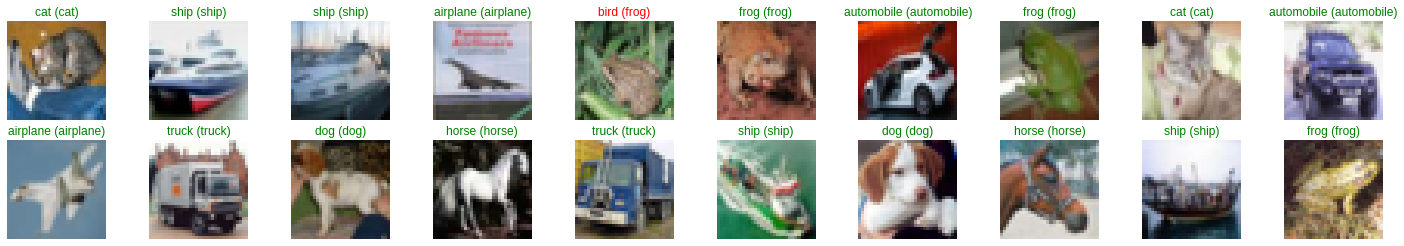

In [0]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))